# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.linear_model import LogisticRegression

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from bs4 import BeautifulSoup

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [03:37<00:00, 1672.18it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

  0%|                                                                                                                               | 309/364171 [00:00<04:00, 1512.71it/s]C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|███████▋                                                                                                                     | 22415/364171 [00:16<05:06, 1113.33it/s]C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 10%|████████████▎                                                                                                                | 35983/364171 [00:28<

<b> Storing the cleaned text into column</b>

In [12]:
# creating other column for the cleaned data
final['cleaned_Texts']=preprocessed_reviews
final['cleaned_Summaries']=preprocessed_summaries


<b>Sort the data by time and get top 100k Records</b>

In [13]:
final_sorted=final.sort_values(by='Time')[:100000]   # rest parameters are default

<h1>Important Functions</h1>

In [14]:
def AVGW2V(dataset,w2v_model):
    '''
    This function takes a data consisting of cleaned and preprocessed text reviews and word2vec training model 
    and converts them into vectors.
    Returns: 500 dimensional vectors.
    '''
    
    w2v_words=list(w2v_model.wv.vocab)    
    list_of_sentences=[]
    
    for sentence in dataset:
        list_of_sentences.append(sentence.split())
       
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentences): # for each review/sentence
        sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors


def TFIDFW2V(dataset,w2v_model,tfidf_vect):    
    '''
    This function takes a dataset containing reviews, word2vec model and tfidf vectorizer model.
    Returns: 500 dimensional vectors. 
    '''
    
    list_of_sentences=[]
    tfidf_sent_vectors = []; 
    
    dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))
    tfidf_feat = tfidf_vect.get_feature_names()  
    w2v_words = list(w2v_model.wv.vocab)             
    
    for sentence in dataset:
        list_of_sentences.append(sentence.split())
    
    row=0;
    for sent in tqdm(list_of_sentences): # for each review/sentence 
        sent_vec = np.zeros(500) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
#               tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)   # tf_idf should be only 50 dimensional because 
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    # top 500 features 
    return tfidf_sent_vectors

def vectorize_standardarize_data(vectorizer,train,test,w2v_model):
    '''
    This function takes vectorizer, train, test and w2v_model parameters.

    Input Parameters:
    vectorizer : It can take values 'bow', 'tfidf', 'avgw2v' and 'tfidfw2v'
    train      : train dataset
    test       : test dataset
    w2v_model  : word2vec trained model 
        
    It converts the text into vectors and stanadarizes train and test data.
    
    Returns: vectorized and standarized train and test datasets.    
    '''
    
    data={}
    
    if vectorizer == 'bow':
        count_vect=CountVectorizer(max_features=500,dtype='float64')  
        train=count_vect.fit_transform(train)
        test=count_vect.transform(test)
        data['vectorizer']=count_vect
        
    elif vectorizer == 'tfidf':
        tfidf_vect=TfidfVectorizer(max_features=500,dtype='float64',ngram_range=(1,2))
        train=tfidf_vect.fit_transform(train)
        test=tfidf_vect.transform(test)
        data['vectorizer']=tfidf_vect
        
    elif vectorizer == 'avgw2v':
        train=AVGW2V(train,w2v_model)     ##np.array(AVGW2V(train,w2v_model))
        test=AVGW2V(test,w2v_model)      ###np.array(AVGW2V(test,w2v_model))
        
    elif vectorizer == 'tfidfw2v':
        tfidf_vect = TfidfVectorizer(max_features=500,ngram_range=(1,2),dtype='float64')
        tfidf_vect.fit(train)   
        train=TFIDFW2V(train,w2v_model,tfidf_vect)
        test=TFIDFW2V(test,w2v_model,tfidf_vect)
    
    # standarize the data
    scalar=StandardScaler(with_mean=False)
    train=scalar.fit_transform(train)
    test=scalar.transform(test)

    data['test']=test
    data['train']=train

    return data

    
def plot_auc_vs_hyperpameter(param_grid,grid):
    '''
    This function plots the variation of auc of roc for train and cv data using Grid Search.
    Returns : optimal number of neighbours
    '''
    plt.close()
    plt.plot(np.log10(param_grid['C']),grid.cv_results_['mean_test_score'],label='Validation AUC')
    plt.plot(np.log10(param_grid['C']),grid.cv_results_['mean_train_score'],label='Train AUC')
    
    plt.xlabel('Log of C')
    plt.ylabel('Area under ROC Curve')
    plt.title('Area under ROC curve V/S Log of Hyper Parameter for CV and train datasets')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    
    optimal_alpha=grid.best_params_['C']        
    
    return optimal_alpha


def plot_roc_curve(train_x,train_y,test_x,test_y,estimator):
    '''
    This curve takes train and test datasets, estimator to plot roc curves for train 
    and test datasets. Please initialize the estimator with necessary parameters before calling this function.
    Returns: a dictionary "auc_and_Ypred" containing test data auc and predicted test scores.
    '''
    plt.close()
    estimator.fit(train_x,train_y)
    
    test_y_pred_prob_score=estimator.predict_proba(test_x)[:,1]
    fpr_test,tpr_test,thresholds_test=roc_curve(test_y,test_y_pred_prob_score)
    

    test_y_pred=estimator.predict(test_x)    
    train_y_pred=estimator.predict(train_x)
    
    plt.plot(fpr_test,tpr_test,'r',label='TEST')
    
    train_y_pred_prob_score=estimator.predict_proba(train_x)[:,1]
    fpr_train,tpr_train,thresholds_train=roc_curve(train_y,train_y_pred_prob_score)
    plt.plot(fpr_train,tpr_train,'b',label='TRAIN')
    
    # print auc for roc for test
    print('ROC AUC for test data',roc_auc_score(test_y,test_y_pred_prob_score)) 
    
   
    # plot roc curve
    plt.plot([0,1],[0,1],'k')
    
    plt.title('ROC for TRAIN and TEST data')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.legend()
    plt.show() 
    
    best_auc=roc_auc_score(test_y,test_y_pred_prob_score)
    auc_and_Ypred={}
    auc_and_Ypred['best_auc']=best_auc
    auc_and_Ypred['y_pred_test']=test_y_pred
    auc_and_Ypred['y_pred_train']=train_y_pred
      
    return auc_and_Ypred
  
    
def plot_confusion_matrix(y_actual,y_pred,dataset_type):
    '''
    This function takes test class labels and predicted class labels and plots confusion matrix.
    dataset_type parameter can take either of two values "Train" and "Test".
    '''

    cm=confusion_matrix(y_actual,y_pred)
    
    label=pd.DataFrame(cm)
    label.iloc[0,0]='TN={}'.format(label.iloc[0,0])
    label.iloc[0,1]='FN={}'.format(label.iloc[0,1])
    label.iloc[1,0]='FP={}'.format(label.iloc[1,0])
    label.iloc[1,1]='TP={}'.format(label.iloc[1,1])
    
    plt.close()
    plt.figure(figsize=(6,4))   

    sns.heatmap(cm,xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'],
                cmap='Dark2',annot=label,linewidths=1,linecolor='black',fmt='s')
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix for ' + dataset_type + ' data')
    plt.show() 



<b>split the data into train and test</b>

In [15]:
train_x,test_x,train_y, test_y=train_test_split(final_sorted['cleaned_Texts'],final_sorted['Score'],test_size=0.3)

print('train_x shape:',train_x.shape,'\n','test_x shape:',test_x.shape,'\n','train_y shape:',train_y.shape,'\n','test_y shape:',test_y.shape)

train_x shape: (70000,) 
 test_x shape: (30000,) 
 train_y shape: (70000,) 
 test_y shape: (30000,)


# [4] Featurization

## [4.1] BAG OF WORDS

<b>vectorize and standardize train and test data using BOW</b>

In [16]:
#BoW

bow = vectorize_standardarize_data('bow',train_x,test_x,w2v_model=None)
set1_x, set1_x_test,count_vect = bow['train'],bow['test'],bow['vectorizer']

print("the type of train and test vectorizer ",type(set1_x),type(set1_x_test))
print("the shape of train and test vectorizer ",set1_x.get_shape(),set1_x_test.get_shape())
print("the number of unique words in train and test", set1_x.get_shape()[1],set1_x_test.get_shape()[1])
print(count_vect.get_feature_names()[:10])

the type of train and test vectorizer  <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500
['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'also', 'alternative']


## [4.2] Bi-Grams and n-Grams.

In [17]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

<b>vectorize and standardize train and test data using TFIDF</b>

In [17]:
#TFIDF

tfidf = vectorize_standardarize_data('tfidf',train_x,test_x,w2v_model=None)

set2_x, set2_x_test,tfidf_vect = tfidf['train'],tfidf['test'],tfidf['vectorizer']

print("the type of train and test vectorizer ",type(set2_x),type(set2_x_test))
print("the shape of train and test vectorizer ",set2_x.get_shape(),set2_x_test.get_shape())
print("the number of unique words in train and test", set2_x.get_shape()[1],set2_x_test.get_shape()[1])
print(tfidf_vect.get_feature_names()[:10])

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)


the type of train and test vectorizer  <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500
['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'also', 'alternative']


## [4.4] Word2Vec

<b>Training word2vec from train data</b>

In [18]:
# Train your own Word2Vec model using your own text corpus

list_of_sentences=[]
for sentence in train_x:
    list_of_sentences.append(sentence.split())
    
w2v_model=Word2Vec(list_of_sentences,min_count=5,size=500)   

In [19]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  15908
sample words  ['excellent', 'business', 'fast', 'shipping', 'highly', 'recommend', 'love', 'peanut', 'chews', 'addicting', 'thanks', 'much', 'jr', 'specialties', 'attempt', 'trick', 'young', 'chefs', 'use', 'cheap', 'artificial', 'oil', 'research', 'truffle', 'not', 'natural', 'piece', 'info', 'included', 'product', 'description', 'least', 'people', 'pay', 'crap', 'selling', 'aware', 'made', 'high', 'end', 'one', 'movie', 'collection', 'filled', 'comedy', 'action', 'whatever', 'else', 'want', 'call']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

<b>vectorize and standardize train and test data using AVGW2V</b>

In [20]:
#AVGW2V

avgw2v = vectorize_standardarize_data('avgw2v',train_x,test_x,w2v_model)

set3_x, set3_x_test = avgw2v['train'],avgw2v['test']
    
print("the type of train and test vectorizer ",type(set3_x),type(set3_x_test))
print("the shape of train and test vectorizer ",set3_x.shape,set3_x_test.shape)
print("the number of unique words in train and test", set3_x.shape[1],set3_x_test.shape[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:29<00:00, 335.30it/s]


the type of train and test vectorizer  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500


#### [4.4.1.2] TFIDF weighted W2v

<b>vectorize and standardize train and test data using TFIDFW2V</b>

In [21]:
#TFIDFW2V

tfidfw2v = vectorize_standardarize_data('tfidfw2v',train_x,test_x,w2v_model)

set4_x, set4_x_test = tfidfw2v['train'],tfidfw2v['test']

print("the type of train and test vectorizer ",type(set4_x),type(set4_x_test))
print("the shape of train and test vectorizer ",set4_x.shape,set4_x_test.shape)
print("the number of unique words in train and test", set4_x.shape[1],set4_x_test.shape[1])

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:30<00:00, 330.85it/s]


the type of train and test vectorizer  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500


<b>parameters grid and pretty print table</b>

In [22]:
# range of C
param_grid={'C':[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]} 

table=PrettyTable(field_names=['Vectorizer','Regularizer','HyperParameter','AUC'])



# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

---------------------- BOW--------------------------


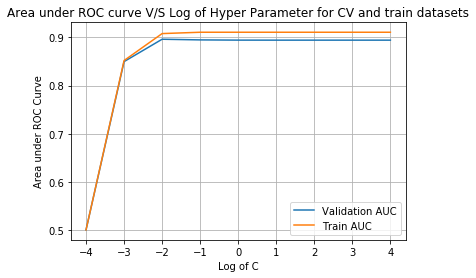

ROC AUC for test data 0.8984084488443208


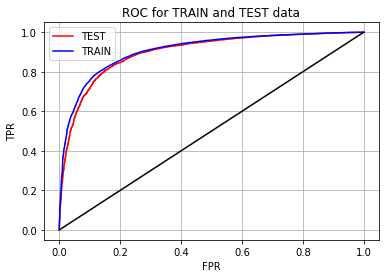

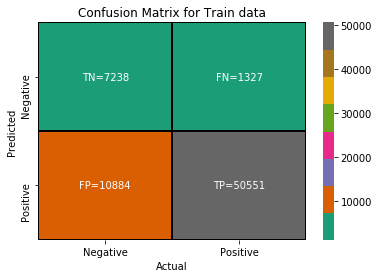

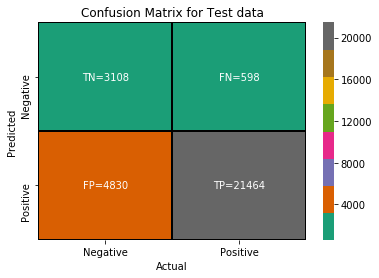

set1_optimal_C: 0.01 set1_best_auc: 0.8984084488443208


In [23]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- BOW--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l1')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set1_x,train_y)    
set1_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)

# Initialize logistic regression algorthm 
set1_clf_l1=LogisticRegression(class_weight='balanced',C=set1_optimal_C)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,train_y,set1_x_test,test_y,set1_clf_l1)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set1_auc_and_Ypred['y_pred_train'],dataset_type='Train')

# plot confusion matrix for test data
plot_confusion_matrix(test_y,set1_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set1_optimal_C:',set1_optimal_C,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW','L1',set1_optimal_C,set1_auc_and_Ypred['best_auc']]

table.add_row(set1_result)


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation

# sparsity i.e. how many zeros out of total
print('sparsity of bow L1 regularized data : ',1-len(np.nonzero(set1_clf_l1.coef_))/set1_x.get_shape()[1])



sparsity of bow L1 regularized data :  0.996


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

---------------------- BOW--------------------------


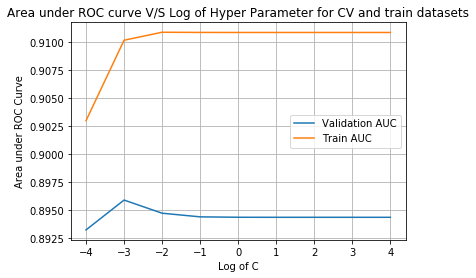

ROC AUC for test data 0.8985905505149521


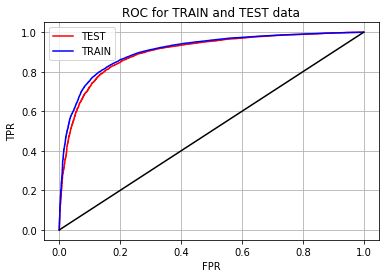

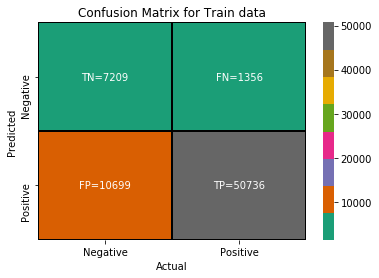

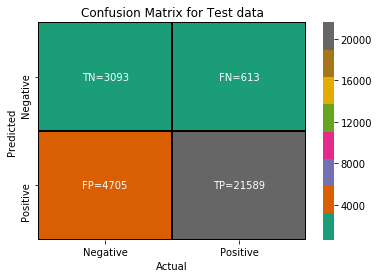

set1_optimal_C: 0.001 set1_best_auc: 0.8985905505149521


In [25]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- BOW--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l2')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set1_x,train_y)    
set1_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)

# Initialize logistic regression algorthm 
set1_clf_l2=LogisticRegression(class_weight='balanced',C=set1_optimal_C)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,train_y,set1_x_test,test_y,set1_clf_l2)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set1_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set1_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set1_optimal_C:',set1_optimal_C,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW','L2',set1_optimal_C,set1_auc_and_Ypred['best_auc']]


table.add_row(set1_result)


In [26]:
1-len(np.nonzero(set1_clf_l2.coef_))/set1_x.get_shape()[1]

0.996

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

Perturbation test is done to check the multicollinearity of features. It happens as follows. A model is trained with
the data. weights of the features are calculated. Then a small noise is added to the data and model is again trained 
with this purturbed data. Weights of the features are calculated. This new weight vector is compared with original 
weights. If the change for a particular feature is high than a threshold then that feature has been impacted by small noise.
So it shows multicollinearity. 

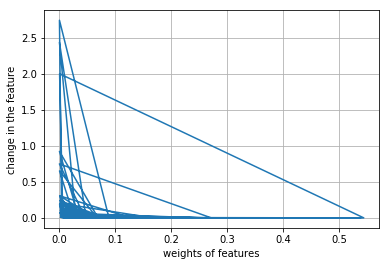

In [27]:
# Please write all the code with proper documentation 

# original weights
weights_original=set1_clf_l2.coef_

# create noise 
noise=np.random.normal(loc=0.0,scale=0.0001,size=set1_x.shape)     

# add noise to original data
set1_x_noisy = set1_x + noise    

# fit the model with this noisy data. 

set1_clf_l2_noisy=LogisticRegression(class_weight='balanced',C=set1_optimal_C)
set1_clf_l2_noisy.fit(set1_x_noisy,train_y)

# Find the new weights
weights_noisy=set1_clf_l2_noisy.coef_


# add perrtubtation to the weights to avoid zero division error.

weights_original+=10**-6    # add 10**-6 data to original weights to avoid zero division error
weights_noisy+=10**-6       # add 10**-6 data to noisy data weights to avoid zero division error

# find the change in the features
change_in_features=np.abs((weights_original-weights_noisy)/weights_original)*100

# plot change_in_features v/s weights_original and find the elbow point i.e. threshold

plt.close()
plt.plot(np.abs(weights_original.ravel()),np.abs(change_in_features.ravel()))
plt.xlabel('weights of features')
plt.ylabel('change in the feature')
plt.grid()
plt.show()



<b> Printing Percentile values </b><br>
We see that there is sharp change from 75 to 100 perctile value.

In [59]:
[ float("{:.8f}".format(float(i))) for i in np.percentile(change_in_features,[0,25,50,75,100])]

[9.14e-06, 0.00158224, 0.00378921, 0.01040783, 2.74354285]

<b>Finding multicolinear features. From the above plot, we now find the features where change was more than 2%</b>

I am considering 2% as threshold value and if there is change in vector more than that then those features are
multicollinear 

In [28]:
weights_original=weights_original.ravel()
multicolinear_features_indices=np.where([change_in_features.ravel()>=2])[1]   
print([count_vect.get_feature_names()[index] for index in multicolinear_features_indices])

['compared', 'noodles', 'stuff']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [29]:
# Please write all the code with proper documentation

set1_feature_importance=pd.DataFrame([count_vect.get_feature_names(),list(set1_clf_l1.coef_.ravel())],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features

,feature,log_probability
222,highly,0.294279
488,wonderful,0.318499
263,love,0.320491
265,loves,0.347634
157,excellent,0.366012
333,perfect,0.371203
205,good,0.377793
123,delicious,0.48429
37,best,0.497875
208,great,0.676387


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [30]:
# Please write all the code with proper documentation
set1_feature_importance.sort_values(by='log_probability')[:10]

,feature,log_probability
303,not,-0.678722
128,disappointed,-0.227454
286,money,-0.209316
349,product,-0.199526
493,would,-0.190636
24,away,-0.168029
28,bad,-0.166814
435,taste,-0.159927
451,thought,-0.148085
46,bought,-0.145685


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

---------------------- TFIDF--------------------------


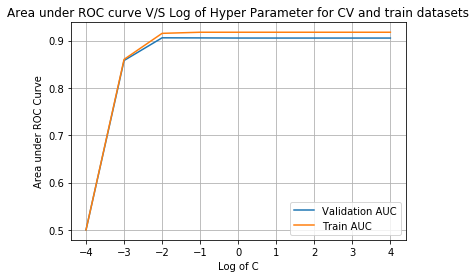

ROC AUC for test data 0.9072851997654814


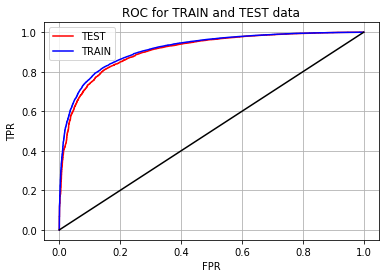

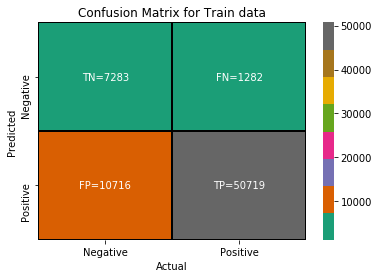

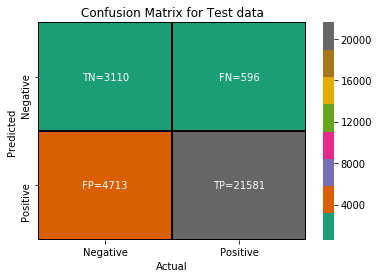

set2_optimal_C: 0.01 set2_best_auc: 0.9072851997654814


In [31]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- TFIDF--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l1')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set2_x,train_y)    
set2_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)


# Initialize logistic regression algorthm 
set2_clf_l1=LogisticRegression(class_weight='balanced',C=set2_optimal_C)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,train_y,set2_x_test,test_y,set2_clf_l1)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set2_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set2_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set2_optimal_C:',set2_optimal_C,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF','L1',set2_optimal_C,set2_auc_and_Ypred['best_auc']]

table.add_row(set2_result)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

---------------------- TFIDF--------------------------


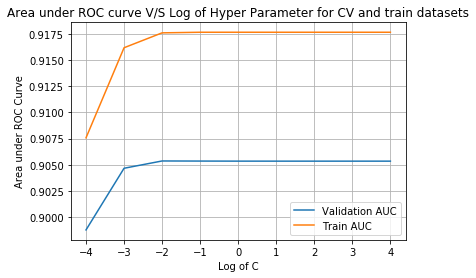

ROC AUC for test data 0.9072851997654814


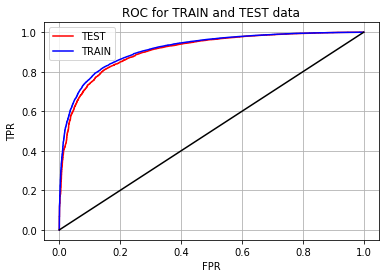

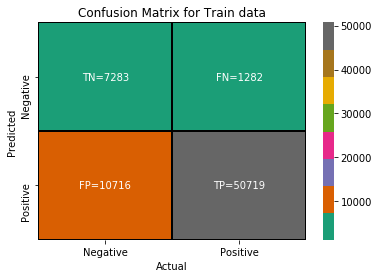

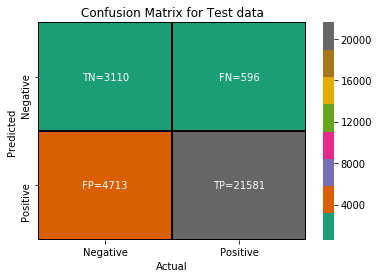

set2_optimal_C: 0.01 set2_best_auc: 0.9072851997654814


In [32]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- TFIDF--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l2')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set2_x,train_y)    
set2_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)


# Initialize logistic regression algorthm 
set2_clf_l2=LogisticRegression(class_weight='balanced',C=set2_optimal_C)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,train_y,set2_x_test,test_y,set2_clf_l2)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set2_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set2_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set2_optimal_C:',set2_optimal_C,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF','L2',set2_optimal_C,set2_auc_and_Ypred['best_auc']]

table.add_row(set2_result)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [33]:
# Please write all the code with proper documentation

set2_feature_importance=pd.DataFrame([tfidf_vect.get_feature_names(),list(set2_clf_l1.coef_.ravel())],index=['feature','log_probability']).T

set2_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features


,feature,log_probability
161,favorite,0.292842
489,wonderful,0.344425
260,love,0.35862
262,loves,0.362055
197,good,0.370938
336,perfect,0.373671
150,excellent,0.397226
117,delicious,0.490794
37,best,0.545731
200,great,0.70365


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [34]:
# Please write all the code with proper documentation

set2_feature_importance.sort_values(by='log_probability')[:10] 

,feature,log_probability
300,not,-0.500356
122,disappointed,-0.206011
282,money,-0.197943
351,product,-0.165027
24,away,-0.147511
435,taste,-0.147049
28,bad,-0.142908
453,thought,-0.140787
225,however,-0.119389
320,ordered,-0.118881


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [35]:
set3_x_original,set3_x_test_original,train_y_original,test_y_original=set3_x,set3_x_test,train_y,test_y
set3_x,set3_x_test,train_y,test_y=set3_x_original[:7000],set3_x_test_original[:3000],train_y_original[:7000],test_y_original[:3000]

In [37]:
set3_x,set3_x_test,train_y,test_y=set3_x_original[:7000],set3_x_test_original[:3000],train_y_original[:7000],test_y_original[:3000]

In [38]:

print(set3_x.shape,set3_x_test.shape,train_y.shape,test_y.shape)
print(set3_x_original.shape,set3_x_test_original.shape,train_y_original.shape,test_y_original.shape)

(7000, 500) (3000, 500) (7000,) (3000,)
(70000, 500) (30000, 500) (70000,) (30000,)


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

---------------------- AVGW2V--------------------------


C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: Conver

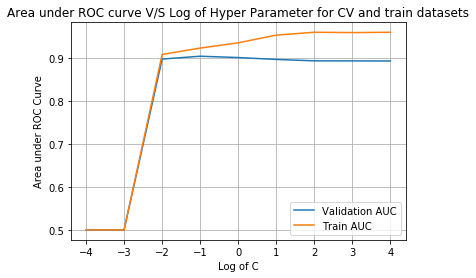

ROC AUC for test data 0.909984275017315


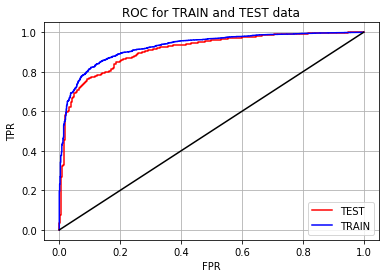

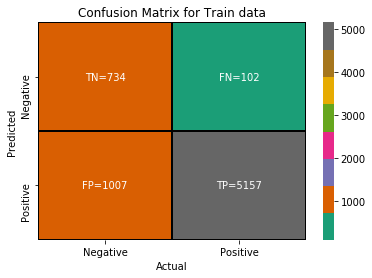

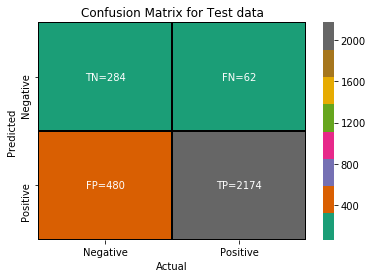

set3_optimal_C: 0.1 set3_best_auc: 0.909984275017315


In [39]:
# Please write all the code with proper documentation

##########
# AVGW2V #
##########

print('---------------------- AVGW2V--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l1')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set3_x,train_y)    
set3_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)


# Initialize logistic regression algorthm 
set3_clf_l1=LogisticRegression(class_weight='balanced',C=set3_optimal_C)

# find the test dataset roc auc and predicted class labels
set3_auc_and_Ypred=plot_roc_curve(set3_x,train_y,set3_x_test,test_y,set3_clf_l1)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set3_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set3_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set3_optimal_C:',set3_optimal_C,'set3_best_auc:',set3_auc_and_Ypred['best_auc'])
set3_result=['AVGW2V','L1',set3_optimal_C,set3_auc_and_Ypred['best_auc']]

table.add_row(set3_result)

In [40]:
print(set3_x.shape,set3_x_test.shape,train_y.shape,test_y.shape)

(7000, 500) (3000, 500) (7000,) (3000,)


In [79]:
# set3_x,set3_x_test,train_y,test_y=set3_x_original,set3_x_test_original,train_y_original,test_y_original

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

---------------------- AVGW2V--------------------------


C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: Conver

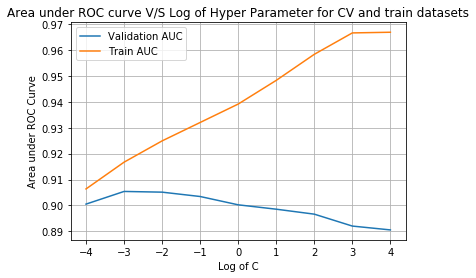

ROC AUC for test data 0.9071365721280127


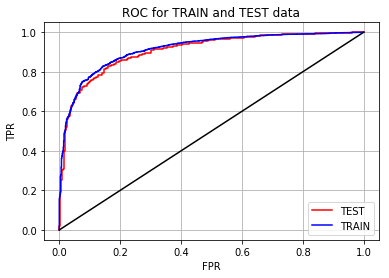

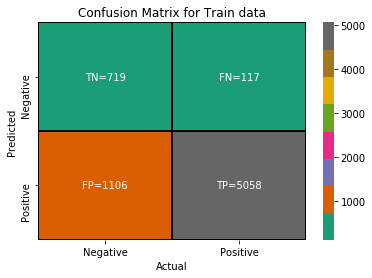

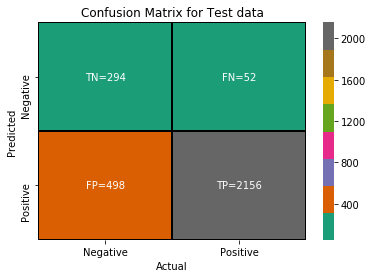

set3_optimal_C: 0.001 set3_best_auc: 0.9071365721280127


In [41]:
# Please write all the code with proper documentation


##########
# AVGW2V #
##########

print('---------------------- AVGW2V--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l2')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set3_x,train_y)    
set3_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)


# Initialize logistic regression algorthm 
set3_clf_l2=LogisticRegression(class_weight='balanced',C=set3_optimal_C)

# find the test dataset roc auc and predicted class labels
set3_auc_and_Ypred=plot_roc_curve(set3_x,train_y,set3_x_test,test_y,set3_clf_l2)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set3_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set3_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set3_optimal_C:',set3_optimal_C,'set3_best_auc:',set3_auc_and_Ypred['best_auc'])
set3_result=['AVGW2V','L2',set3_optimal_C,set3_auc_and_Ypred['best_auc']]
table.add_row(set3_result)


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [42]:
set4_x_original,set4_x_test_original,train_y_original,test_y_original=set4_x,set4_x_test,train_y,test_y
set4_x,set4_x_test,train_y,test_y=set4_x_original[:7000],set4_x_test_original[:3000],train_y_original[:7000],test_y_original[:3000]


In [43]:
print(set4_x.shape,set4_x_test.shape,train_y.shape,test_y.shape)
print(set4_x_original.shape,set4_x_test_original.shape,train_y_original.shape,test_y_original.shape)

(7000, 500) (3000, 500) (7000,) (3000,)
(70000, 500) (30000, 500) (7000,) (3000,)


---------------------- AVGW2V--------------------------


C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: Conver

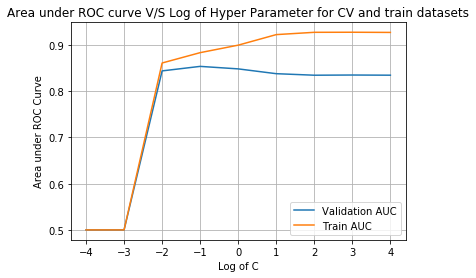

ROC AUC for test data 0.855598050276385


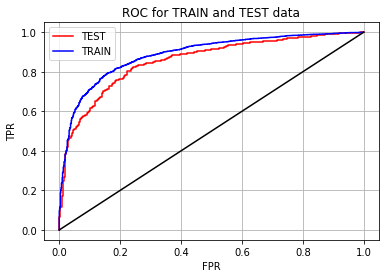

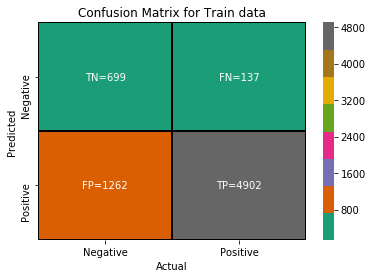

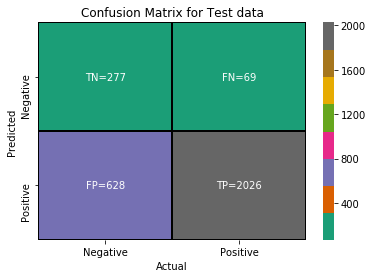

set4_optimal_C: 0.1 set4_best_auc: 0.855598050276385


In [44]:
# Please write all the code with proper documentation

##########
# TFIDFW2V #
##########

print('---------------------- AVGW2V--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l1')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set4_x,train_y)    
set4_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)


# Initialize logistic regression algorthm 
set4_clf_l1=LogisticRegression(class_weight='balanced',C=set4_optimal_C)

# find the test dataset roc auc and predicted class labels
set4_auc_and_Ypred=plot_roc_curve(set4_x,train_y,set4_x_test,test_y,set4_clf_l1)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set4_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set4_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set4_optimal_C:',set4_optimal_C,'set4_best_auc:',set4_auc_and_Ypred['best_auc'])
set4_result=['TFIDFW2V','L1',set4_optimal_C,set4_auc_and_Ypred['best_auc']]

table.add_row(set4_result)


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [45]:
print(set4_x.shape,set4_x_test.shape,train_y.shape,test_y.shape)
print(set4_x_original.shape,set4_x_test_original.shape,train_y_original.shape,test_y_original.shape)

(7000, 500) (3000, 500) (7000,) (3000,)
(70000, 500) (30000, 500) (7000,) (3000,)


---------------------- TFIDFW2V--------------------------


C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: Conver

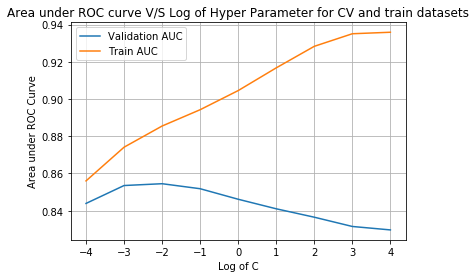

ROC AUC for test data 0.8579361069124585


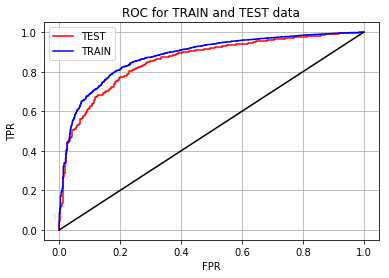

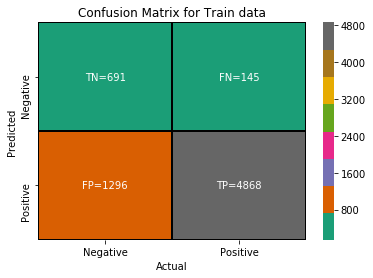

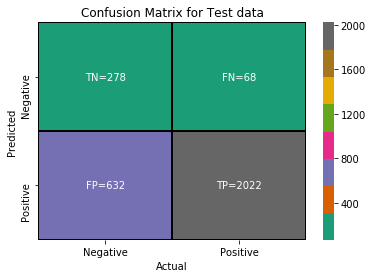

set4_optimal_C: 0.01 set4_best_auc: 0.8579361069124585


In [46]:

# Please write all the code with proper documentation

##########
# TFIDFW2V #
##########

print('---------------------- TFIDFW2V--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l2')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal C
grid.fit(set4_x,train_y)    
set4_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)

# Initialize logistic regression algorthm 
set4_clf_l2=LogisticRegression(class_weight='balanced',C=set4_optimal_C)

# find the test dataset roc auc and predicted class labels
set4_auc_and_Ypred=plot_roc_curve(set4_x,train_y,set4_x_test,test_y,set4_clf_l2)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set4_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set4_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set4_optimal_C:',set4_optimal_C,'set4_best_auc:',set4_auc_and_Ypred['best_auc'])
set4_result=['TFIDFW2V','L2',set4_optimal_C,set4_auc_and_Ypred['best_auc']]

table.add_row(set4_result)

<h1>feature engineering on set1(bow) and set2(tfidf)</h1>

As part of feature engineering, I am combining the data from review summary and text and adding it as extra column. 
I am also adding length of this combined data as another column.

<b> combine text and summary and store into a new column and train-test split</b>

In [47]:
final_sorted['Text_Summary']=final_sorted['cleaned_Texts']+final_sorted['cleaned_Summaries']

train_x,test_x,train_y, test_y=train_test_split(final_sorted['Text_Summary'],final_sorted['Score'],test_size=0.3)

print('train_x shape:',train_x.shape,'\n','test_x shape:',test_x.shape,'\n','train_y shape:',train_y.shape,'\n','test_y shape:',test_y.shape)

train_x shape: (70000,) 
 test_x shape: (30000,) 
 train_y shape: (70000,) 
 test_y shape: (30000,)


<b> We find the length of review summaries and review texts and standarize them.</b>

In [48]:
# find the length of combined text from review summary and review text and 

train_x_lengths = np.reshape([ len(review.split()) for review in train_x ],(-1,1))
test_x_lengths = np.reshape([ len(review.split()) for review in test_x ], (-1,1))

scalar=StandardScaler(with_mean=False)
train_x_lengths=scalar.fit_transform(train_x_lengths)
test_x_lengths=scalar.transform(test_x_lengths)

print('train_x_lengths:',train_x_lengths.shape,'\n','test_x_lengths',test_x_lengths.shape)

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


train_x_lengths: (70000, 1) 
 test_x_lengths (30000, 1)


<b>convert text data into vectors using BOW(set1) and TFIDF(set2)</b>

In [49]:
# set1 bow
bow = vectorize_standardarize_data('bow',train_x,test_x,w2v_model=None)
set1_x, set1_x_test,count_vect = bow['train'],bow['test'],bow['vectorizer']

# set2 tfidf
tfidf = vectorize_standardarize_data('tfidf',train_x,test_x,w2v_model=None)
set2_x, set2_x_test,tfidf_vect = tfidf['train'],tfidf['test'],tfidf['vectorizer']

C:\Users\rap\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)


<b>Add an extra column containing the length of combined review text and summary </b>

In [50]:
# Add 1 extra column which contains the length of combined texts from review texts and review summary.

set1_x=np.hstack((set1_x.toarray(), train_x_lengths))
set1_x_test=np.hstack((set1_x_test.toarray(), test_x_lengths))

set2_x=np.hstack((set2_x.toarray(), train_x_lengths))
set2_x_test=np.hstack((set2_x_test.toarray(), test_x_lengths))

print('train_x_lengths:',len(train_x_lengths),'\n','test_x_lengths:',len(test_x_lengths))
print('set1_x: ',set1_x.shape,'\n','set1_x_test:',set1_x_test.shape,'\n','set2_x:',set2_x.shape,'\n','set2_x_test:',set2_x_test.shape)

train_x_lengths: 70000 
 test_x_lengths: 30000
set1_x:  (70000, 501) 
 set1_x_test: (30000, 501) 
 set2_x: (70000, 501) 
 set2_x_test: (30000, 501)


---------------------- BOW--------------------------


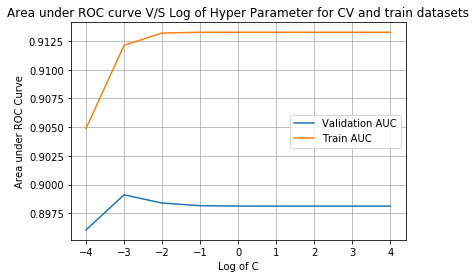

ROC AUC for test data 0.9009604914463054


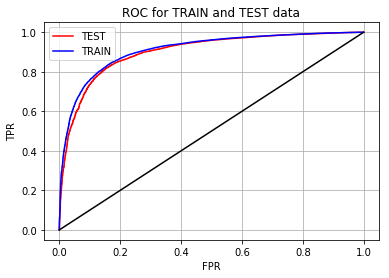

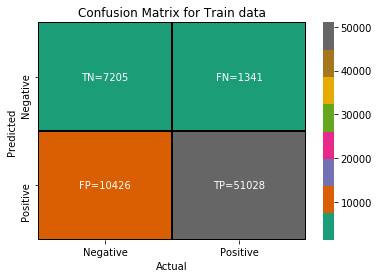

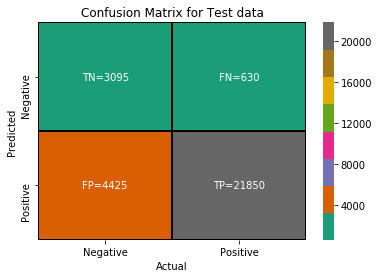

set1_optimal_C: 0.001 set1_best_auc: 0.9009604914463054


In [51]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- BOW--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l2')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal number of neighbors
grid.fit(set1_x,train_y)    
set1_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set1_clf_l2=LogisticRegression(class_weight='balanced',C=set1_optimal_C)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,train_y,set1_x_test,test_y,set1_clf_l2)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set1_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set1_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set1_optimal_C:',set1_optimal_C,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW:FeatureEngineered','L2',set1_optimal_C,set1_auc_and_Ypred['best_auc']]

table.add_row(set1_result)


---------------------- TFIDF--------------------------


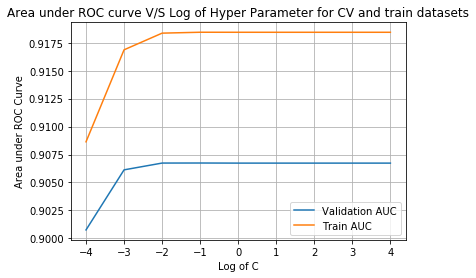

ROC AUC for test data 0.9078655163826078


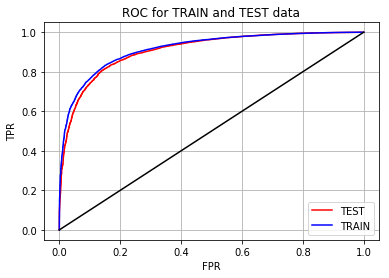

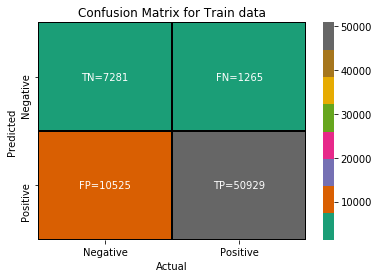

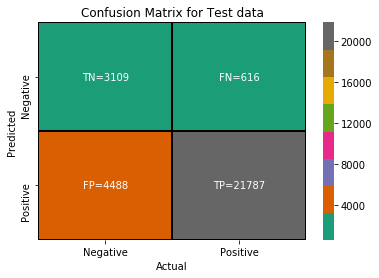

set2_optimal_C: 0.1 set2_best_auc: 0.9078655163826078


In [52]:
# Please write all the code with proper documentation

#########
# TFIDF #
#########

print('---------------------- TFIDF--------------------------')

# Initiliaze the logistic regression model
lr=LogisticRegression(random_state=0,class_weight='balanced',penalty='l2')   

# gridcv initialization
grid=GridSearchCV(lr,param_grid,scoring='roc_auc')

# train the grid and find optimal number of neighbors
grid.fit(set2_x,train_y)    
set2_optimal_C=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set2_clf_l2=LogisticRegression(class_weight='balanced',C=set2_optimal_C)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,train_y,set2_x_test,test_y,set2_clf_l2)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set2_auc_and_Ypred['y_pred_train'],dataset_type='Train')

# plot confusion matrix for test data
plot_confusion_matrix(test_y,set2_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set2_optimal_C:',set2_optimal_C,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF:Feature Engineered','L2',set2_optimal_C,set2_auc_and_Ypred['best_auc']]

table.add_row(set2_result)

# [6] Conclusions

In [53]:
# Please compare all your models using Prettytable library

print(table)

+--------------------------+-------------+----------------+--------------------+
|        Vectorizer        | Regularizer | HyperParameter |        AUC         |
+--------------------------+-------------+----------------+--------------------+
|           BOW            |      L1     |      0.01      | 0.8984084488443208 |
|           BOW            |      L2     |     0.001      | 0.8985905505149521 |
|          TFIDF           |      L1     |      0.01      | 0.9072851997654814 |
|          TFIDF           |      L2     |      0.01      | 0.9072851997654814 |
|          AVGW2V          |      L1     |      0.1       | 0.909984275017315  |
|          AVGW2V          |      L2     |     0.001      | 0.9071365721280127 |
|         TFIDFW2V         |      L1     |      0.1       | 0.855598050276385  |
|         TFIDFW2V         |      L2     |      0.01      | 0.8579361069124585 |
|  BOW:FeatureEngineered   |      L2     |     0.001      | 0.9009604914463054 |
| TFIDF:Feature Engineered |

<p>
1. From AUC values, looks like almost all the models with L1 or L2 regularization perform similar. <br>
2. Feature engieered data L2 TFIDF vectorized data has perfomed best so combinining summary and text  data is worked <br>
   
TFIDF:Feature Engineered |      L2     |      0.1       | 0.9078655163826078 <br>
    
4. Below features are multicollinear features because by slightly perturbing the data they changed more than 2%. <br>
['compared', 'noodles', 'stuff'] <br>

5. During perturbation we found that there was sharp increase in change vector from 75 (0.01040783) to 100 (2.74354285)  percentile value. <br>

6. Looking at Confusion matrix Feature engineered TFIDF L2 gives the improved counts for True negative and True positive. 
</p>